In [25]:
from datasets import load_dataset
import random
import string
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [20]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/deyuq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
emotions = load_dataset("dair-ai/emotion")

In [107]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [108]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [109]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [110]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [111]:
lemmatized_train_data = []
lemmatized_val_data = []
lemmatized_test_data = []
for sentence in train_data["text"]:
    lemmatized_train_data.append(cleaning(sentence))
for sentence in validation_data["text"]:
    lemmatized_val_data.append(cleaning(sentence))
for sentence in test_data["text"]:
    lemmatized_test_data.append(cleaning(sentence))

In [112]:
lemmatized_train_data2 = np.array(lemmatized_train_data).reshape(-1,1)
lemmatized_train_data2

array([['didnt feel humiliate'],
       ['go feel hopeless damn hopeful around someone care awake'],
       ['im grab minute post feel greedy wrong'],
       ...,
       ['feel strong good overall'],
       ['feel like rude comment im glad'],
       ['know lot feel stupid portray']], dtype='<U227')

In [113]:
oversample = RandomOverSampler()
train_text_oversample, train_data_oversample = oversample.fit_resample(lemmatized_train_data2, train_data["label"])
train_text_oversample

array([['didnt feel humiliate'],
       ['go feel hopeless damn hopeful around someone care awake'],
       ['im grab minute post feel greedy wrong'],
       ...,
       ['feel weird take time make sometimes terrible sound people hear'],
       ['gotta say im feel pretty impress everything end consider total dollars drop total three small canvas play display'],
       ['feel amaze didnt find good comment']], dtype='<U227')

In [114]:
train_text_oversample = train_text_oversample.flatten()
len(train_text_oversample)

32172

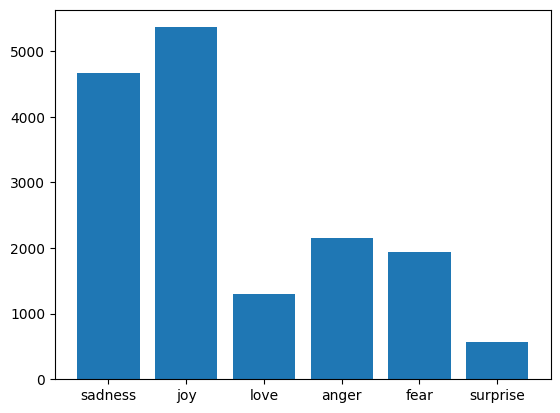

In [115]:
label_count = Counter(train_data["label"])
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

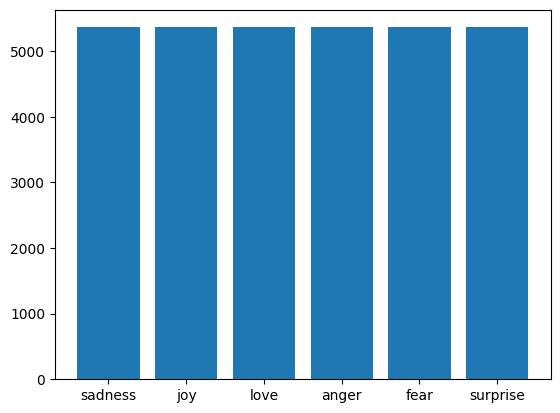

In [116]:
label_count = Counter(train_data_oversample)
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

In [117]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

In [118]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: list, labels: list, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data, labels):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [119]:
train_instances = preprocess(train_text_oversample, train_data_oversample, tokenizer)
val_instances = preprocess(lemmatized_val_data, validation_data["label"], tokenizer)
test_instances = preprocess(lemmatized_test_data, test_data["label"], tokenizer)

In [120]:
len(train_instances)

32172

In [121]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [122]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        for epoch in range(epochs):
            train_batches = batching(
                train_instances,
                batch_size=batch_size,
                shuffle=True)
            
            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # train_f1 = self.evaluate(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate(val_instances, batch_size=batch_size)

            #print(f"Epoch {epoch + 1} train F1 score: {train_f1}, validation F1 score: {val_f1}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")

In [123]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=5, batch_size=16)

  3%|▎         | 54/2011 [00:00<00:10, 179.24it/s]

100%|██████████| 2011/2011 [00:08<00:00, 232.39it/s] 


CNN Classifier:
Accuracy: 0.875
Precision: 0.8417189710145542
Recall: 0.8611037251207336
F1 Score: 0.849603820813218
Confusion Matrix:
[[485  24   2  25  12   2]
 [  8 623  34  25   5   9]
 [  3  26 140   7   2   0]
 [  3   5   2 260   5   0]
 [ 13   5   0  11 173  10]
 [  2   4   0   1   5  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       550
           1       0.91      0.88      0.90       704
           2       0.79      0.79      0.79       178
           3       0.79      0.95      0.86       275
           4       0.86      0.82      0.84       212
           5       0.77      0.85      0.81        81

    accuracy                           0.88      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.88      0.88      0.88      2000



100%|██████████| 2011/2011 [00:10<00:00, 194.13it/s]


CNN Classifier:
Accuracy: 0.883
Precision: 0.8584044519260027
Recall: 0.8598637846212739
F1 Score: 0.8579666362870323
Confusion Matrix:
[[519  14   0   7   9   1]
 [ 24 629  29   7   7   8]
 [  9  29 136   3   1   0]
 [ 23   4   2 238   8   0]
 [ 16   5   0   6 173  12]
 [  5   2   0   0   3  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       550
           1       0.92      0.89      0.91       704
           2       0.81      0.76      0.79       178
           3       0.91      0.87      0.89       275
           4       0.86      0.82      0.84       212
           5       0.77      0.88      0.82        81

    accuracy                           0.88      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.88      0.88      0.88      2000



100%|██████████| 2011/2011 [00:10<00:00, 196.51it/s]


CNN Classifier:
Accuracy: 0.876
Precision: 0.8481602237314293
Recall: 0.849434352674112
F1 Score: 0.8479057655257631
Confusion Matrix:
[[522   5   1   9  12   1]
 [ 29 616  30  11  10   8]
 [  7  31 131   3   5   1]
 [ 25   7   2 234   7   0]
 [ 13   4   0   5 182   8]
 [  4   2   0   0   8  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       550
           1       0.93      0.88      0.90       704
           2       0.80      0.74      0.77       178
           3       0.89      0.85      0.87       275
           4       0.81      0.86      0.83       212
           5       0.79      0.83      0.81        81

    accuracy                           0.88      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.88      0.88      0.88      2000



100%|██████████| 2011/2011 [00:08<00:00, 231.01it/s] 


CNN Classifier:
Accuracy: 0.861
Precision: 0.8293943466267851
Recall: 0.8369896519698433
F1 Score: 0.8311307136978456
Confusion Matrix:
[[512   4   4  19  10   1]
 [ 29 591  38  32   5   9]
 [  7  22 137   9   3   0]
 [ 16   2   0 252   5   0]
 [ 20   1   0  17 167   7]
 [  6   3   0   1   8  63]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       550
           1       0.95      0.84      0.89       704
           2       0.77      0.77      0.77       178
           3       0.76      0.92      0.83       275
           4       0.84      0.79      0.81       212
           5       0.79      0.78      0.78        81

    accuracy                           0.86      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.87      0.86      0.86      2000



100%|██████████| 2011/2011 [00:10<00:00, 199.41it/s]


CNN Classifier:
Accuracy: 0.872
Precision: 0.8467780503723253
Recall: 0.8275676267033988
F1 Score: 0.8351353204568458
Confusion Matrix:
[[491  30   3  15   8   3]
 [  5 657  22   5   6   9]
 [  0  52 121   3   2   0]
 [  7  18   3 242   3   2]
 [  9  17   0   4 170  12]
 [  3   8   1   1   5  63]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       550
           1       0.84      0.93      0.88       704
           2       0.81      0.68      0.74       178
           3       0.90      0.88      0.89       275
           4       0.88      0.80      0.84       212
           5       0.71      0.78      0.74        81

    accuracy                           0.87      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.87      0.87      0.87      2000



In [124]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.863
Precision: 0.8263202920559717
Recall: 0.8177519665921594
F1 Score: 0.8181564901850398
Confusion Matrix:
[[490  46   4  27  10   4]
 [  2 663  20   5   0   5]
 [  2  50 105   1   1   0]
 [  7  17   2 237  12   0]
 [  9   7   0   9 179  20]
 [  1   9   0   0   4  52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       581
           1       0.84      0.95      0.89       695
           2       0.80      0.66      0.72       159
           3       0.85      0.86      0.86       275
           4       0.87      0.80      0.83       224
           5       0.64      0.79      0.71        66

    accuracy                           0.86      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.87      0.86      0.86      2000

